# 목차
###0) 라이브러리 버전 확인

###1) 데이터 준비와 확인

• 데이터의 중복 제거
• NaN 결측치 제거
• 한국어 토크나이저로 토큰화
• 불용어(Stopwords) 제거
• 사전word_to_index 구성
• 텍스트 스트링을 사전 인덱스 스트링으로 변환
• X_train, y_train, X_test, y_test, word_to_index 리턴

###2) 데이터로더 구성
###3) 모델 구성을 위한 데이터 분석 및 가공
###4) 모델 구성 및 validation set 구성
###5) 모델 훈련 개시
###6) Loss, Accuracy 그래프 시각화
###7) 학습된 Embedding 레이어 분석
###8) 한국어 Word2Vec 임베딩 활용하여 성능 개선

#0) 라이브러리 버전 확인

In [1]:
%%bash
apt-get update
apt-get install g++ openjdk-8-jdk python-dev python3-dev
pip3 install JPype1
pip3 install konlpy

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:5 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Fetched 74.6 kB in 2s (40.9 kB/s)
Reading package lists...
Reading pac

In [2]:
%env JAVA_HOME "/usr/lib/jvm/java-8-openjdk-amd64"

env: JAVA_HOME="/usr/lib/jvm/java-8-openjdk-amd64"


In [3]:
%%bash
bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)
pip3 install /tmp/mecab-python-0.996

mecab-ko is already installed
mecab-ko-dic is already installed
mecab-python is already installed
Done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /tmp/mecab-python-0.996
  Created wheel for mecab-python: filename=mecab_python-0.996_ko_0.9.2-cp37-cp37m-linux_x86_64.whl size=141806 sha256=085314c28c3c870329ec69d54bbb9ee2e6ee0374c732ff71c1d424cfc1012660
  Stored in directory: /root/.cache/pip/wheels/40/7b/9f/2922869bef86c3354ae7034f7a3647c573ee1997c2dad0290a
Failed to build mecab-python
  Attempting uninstall: mecab-python
    Found existing installation: mecab-python 0.996-ko-0.9.2
    Uninstalling mecab-python-0.996-ko-0.9.2:
      Successfully uninstalled mecab-python-0.996-ko-0.9.2
    Running setup.py install for mecab-python: started
    Running setup.py install for mecab-python: finished with status 'done'


  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  DEPRECATION: mecab-python was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


In [4]:
import pandas
import konlpy
import gensim

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.5
0.6.0
3.6.0


#1) 데이터 준비와 확인

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('/content/drive/MyDrive/Aiffel_data/Exp8_NLP2/ratings_train.txt')
test_data = pd.read_table('/content/drive/MyDrive/Aiffel_data/Exp8_NLP2/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


#2) 데이터로더 구성

* 데이터의 중복 제거
*  NaN 결측치 제거
*  한국어 토크나이저로 토큰화
*  불용어(Stopwords) 제거
*  사전word_to_index 구성
*  텍스트 스트링을 사전 인덱스 스트링으로 변환
*  X_train, y_train, X_test, y_test, word_to_index 리턴

num_words > 숫자로
숫자 > num_words


In [7]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter
import tensorflow as tf

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(num_words-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 


In [8]:
len(X_train)

146182

In [9]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [10]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

#3) 모델 구성을 위한 데이터 분석 및 가공
* 데이터셋 내 문장 길이 분포
* 적절한 최대 문장 길이 지정
* keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

3119443
문장길이 평균 :  15.96938143432699
문장길이 최대 :  116
문장길이 표준편차 :  12.843571939469296


pad_sequences maxlen :  48
전체 문장의 0.9548784420929768%가 maxlen 설정값 이내에 포함됩니다. 


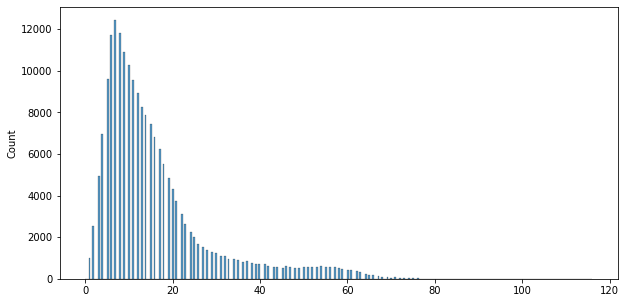

In [11]:
# 데이터셋 내 문장 길이 분포
# 적절한 최대 문장 길이 지정 


total_data_text = list(X_train) + list(X_test)

# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
num_tokens_count = np.bincount(num_tokens)

# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다.
print(np.sum(num_tokens))

print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))
print('\n')

# 예를들어, 최대 길이를 (평균 + 2.5*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2.5* np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize= (10,5))
sns.histplot(num_tokens)
plt.show()

In [12]:
num_tokens_count

array([    5,  1015,  2554,  4951,  6936,  9580, 11741, 12441, 11822,
       10907, 10287,  9531,  8929,  8253,  7867,  7440,  6823,  6259,
        5535,  4868,  4312,  3746,  3136,  2653,  2242,  1993,  1688,
        1512,  1376,  1270,  1241,  1108,  1074,   947,   951,   927,
         814,   854,   763,   714,   728,   712,   623,   583,   580,
         537,   593,   576,   528,   499,   547,   560,   573,   587,
         597,   583,   569,   567,   539,   455,   438,   409,   358,
         306,   254,   193,   171,   132,    97,    88,    58,    63,
          39,    26,    15,    26,    22,     8,     8,     7,     4,
           2,     2,     1,     1,     1,     2,     0,     2,     0,
           0,     0,     0,     1,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     1,     1,     0,
           0,     0,     0,     0,     0,     0,     0,     1,     1])

In [13]:
total_data_text = list(X_train) + list(X_test)

# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))
print('\n')

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2* np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96938143432699
문장길이 최대 :  116
문장길이 표준편차 :  12.843571939469296


pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [14]:
# 패딩 추가
import tensorflow as tf
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


#4) 모델 구성 및 validation set 구성
* 모델은 3가지 이상 다양하게 구성하여 실험해 보기
* LSTM
* CNN
* GMP

In [15]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터) # 깊을수록 과적합 / 연산량 증가 

# model 설계 - LSTM

model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_lstm.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model_lstm.add(tf.keras.layers.Dense(8, activation='relu'))
model_lstm.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.


model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160000    
                                                                 
 lstm (LSTM)                 (None, 8)                 800       
                                                                 
 dense (Dense)               (None, 8)                 72        
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [16]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 16   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

# 모델 설계 - CNN

model_cnn = tf.keras.Sequential()
model_cnn .add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_cnn .add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_cnn .add(tf.keras.layers.MaxPooling1D(5))
model_cnn .add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_cnn .add(tf.keras.layers.GlobalMaxPooling1D())
model_cnn .add(tf.keras.layers.Dense(8, activation='relu'))
model_cnn .add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_cnn .summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 16)          160000    
                                                                 
 conv1d (Conv1D)             (None, None, 16)          1808      
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 16)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, None, 16)          1808      
                                                                 
 global_max_pooling1d (Globa  (None, 16)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_2 (Dense)             (None, 8)                

In [17]:
# vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
# word_vector_dim = 4   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

# # 모델 설계 - CNN

# model_cnn = tf.keras.Sequential()
# model_cnn .add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
# model_cnn .add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
# model_cnn .add(tf.keras.layers.MaxPooling1D(5))
# model_cnn .add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
# model_cnn .add(tf.keras.layers.GlobalMaxPooling1D())
# model_cnn .add(tf.keras.layers.Dense(8, activation='relu'))
# model_cnn .add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

# model_cnn .summary()

In [18]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 16   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

# 모델 설계 - GMP :Gloabal Max Pooling1D()

model_gmp = tf.keras.Sequential()
model_gmp.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_gmp.add(tf.keras.layers.GlobalMaxPooling1D())
model_gmp.add(tf.keras.layers.Dense(8, activation='relu'))
model_gmp.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_gmp.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 16)          160000    
                                                                 
 global_max_pooling1d_1 (Glo  (None, 16)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 8)                 136       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


In [19]:
# validation set 40000건 분리
X_val = X_train[:40000]   
Y_val = y_train[:40000]

# validation set을 제외한 나머지 
partial_X_train = X_train[40000:]  
partial_Y_train = y_train[40000:]

print(partial_X_train.shape)
print(partial_Y_train.shape)

(106182, 41)
(106182,)


#5) 모델 훈련 _Loss, Accuracy 그래프 시각화


###1)LSTM
* loss: 0.5005 - accuracy: 0.8303

In [20]:
model_lstm.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model_lstm.fit(partial_X_train,
                    partial_Y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, Y_val),
                    verbose=1)

Epoch 1/20
208/208 [==============================] - 4s 10ms/step - loss: 0.6460 - accuracy: 0.5945 - val_loss: 0.4629 - val_accuracy: 0.8116
Epoch 2/20
208/208 [==============================] - 2s 8ms/step - loss: 0.3854 - accuracy: 0.8354 - val_loss: 0.3575 - val_accuracy: 0.8424
Epoch 3/20
208/208 [==============================] - 1s 7ms/step - loss: 0.3299 - accuracy: 0.8619 - val_loss: 0.3507 - val_accuracy: 0.8465
Epoch 4/20
208/208 [==============================] - 1s 7ms/step - loss: 0.3117 - accuracy: 0.8687 - val_loss: 0.3615 - val_accuracy: 0.8417
Epoch 5/20
208/208 [==============================] - 2s 7ms/step - loss: 0.3010 - accuracy: 0.8736 - val_loss: 0.3524 - val_accuracy: 0.8479
Epoch 6/20
208/208 [==============================] - 1s 7ms/step - loss: 0.2907 - accuracy: 0.8773 - val_loss: 0.3555 - val_accuracy: 0.8457
Epoch 7/20
208/208 [==============================] - 2s 8ms/step - loss: 0.2801 - accuracy: 0.8815 - val_loss: 0.3692 - val_accuracy: 0.8480
Epoch

In [21]:
results = model_lstm.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.4920 - accuracy: 0.8358 - 4s/epoch - 2ms/step
[0.49204695224761963, 0.8357710838317871]


In [22]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


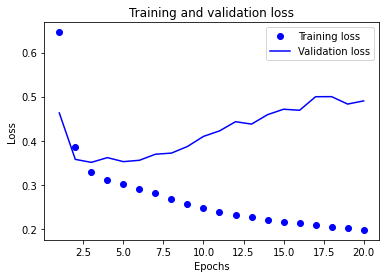

In [23]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

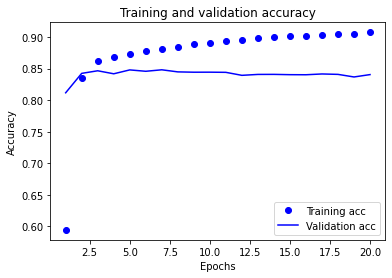

In [24]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

###1)CNN
* loss: 0.9274 - accuracy: 0.8107

In [25]:
model_cnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model_cnn.fit(partial_X_train,
                    partial_Y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, Y_val),
                    verbose=1)

Epoch 1/20
208/208 [==============================] - 3s 7ms/step - loss: 0.5136 - accuracy: 0.7474 - val_loss: 0.3650 - val_accuracy: 0.8412
Epoch 2/20
208/208 [==============================] - 1s 5ms/step - loss: 0.3379 - accuracy: 0.8569 - val_loss: 0.3471 - val_accuracy: 0.8487
Epoch 3/20
208/208 [==============================] - 1s 6ms/step - loss: 0.3040 - accuracy: 0.8734 - val_loss: 0.3448 - val_accuracy: 0.8503
Epoch 4/20
208/208 [==============================] - 1s 6ms/step - loss: 0.2781 - accuracy: 0.8877 - val_loss: 0.3512 - val_accuracy: 0.8492
Epoch 5/20
208/208 [==============================] - 1s 6ms/step - loss: 0.2519 - accuracy: 0.9007 - val_loss: 0.3583 - val_accuracy: 0.8486
Epoch 6/20
208/208 [==============================] - 1s 5ms/step - loss: 0.2214 - accuracy: 0.9157 - val_loss: 0.3766 - val_accuracy: 0.8467
Epoch 7/20
208/208 [==============================] - 1s 6ms/step - loss: 0.1886 - accuracy: 0.9310 - val_loss: 0.4071 - val_accuracy: 0.8444
Epoch 

In [26]:
results = model_cnn.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 1.0055 - accuracy: 0.8137 - 3s/epoch - 2ms/step
[1.0054808855056763, 0.813698947429657]


In [27]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


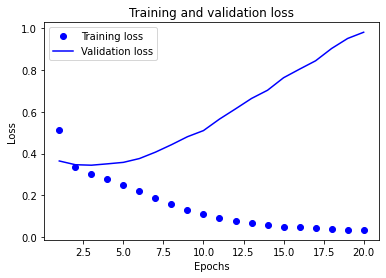

In [28]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.clf() 
# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

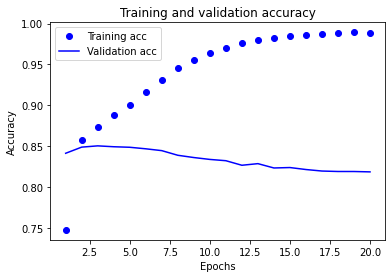

In [29]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

###3)GMP(Global Max Pooling)
* loss: 0.6933 - accuracy: 0.4977

In [30]:
model_gmp.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model_lstm.fit(partial_X_train,
                    partial_Y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, Y_val),
                    verbose=1)

Epoch 1/20
208/208 [==============================] - 2s 7ms/step - loss: 0.1950 - accuracy: 0.9080 - val_loss: 0.5119 - val_accuracy: 0.8367
Epoch 2/20
208/208 [==============================] - 2s 7ms/step - loss: 0.1913 - accuracy: 0.9092 - val_loss: 0.5118 - val_accuracy: 0.8383
Epoch 3/20
208/208 [==============================] - 1s 7ms/step - loss: 0.1891 - accuracy: 0.9096 - val_loss: 0.5241 - val_accuracy: 0.8382
Epoch 4/20
208/208 [==============================] - 1s 7ms/step - loss: 0.1860 - accuracy: 0.9114 - val_loss: 0.5213 - val_accuracy: 0.8287
Epoch 5/20
208/208 [==============================] - 1s 7ms/step - loss: 0.1841 - accuracy: 0.9121 - val_loss: 0.5331 - val_accuracy: 0.8376
Epoch 6/20
208/208 [==============================] - 2s 7ms/step - loss: 0.1829 - accuracy: 0.9133 - val_loss: 0.5350 - val_accuracy: 0.8333
Epoch 7/20
208/208 [==============================] - 1s 7ms/step - loss: 0.1792 - accuracy: 0.9150 - val_loss: 0.5528 - val_accuracy: 0.8328
Epoch 

In [31]:
results = model_gmp.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.6935 - accuracy: 0.4973 - 3s/epoch - 2ms/step
[0.6935251951217651, 0.4972638785839081]


In [32]:
history_dict = history.history

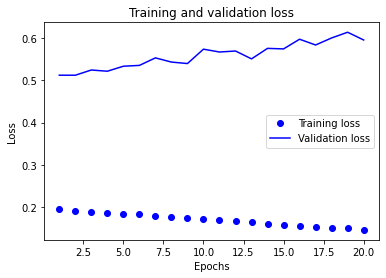

In [33]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.clf() 
# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

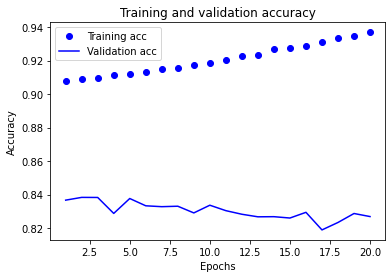

In [34]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#6) 학습된 Embedding 레이어 분석


In [35]:
!pip list | grep gensim

gensim                        3.6.0


### 1)LSTM 

In [36]:
embedding_layer = model_lstm.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [99]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = '/content/drive/MyDrive/Aiffel_data/Exp8_NLP2/word2vec_lstm.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model_lstm.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [100]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['사탕']
vector

array([ 1.9818382 , -1.2061443 ,  0.26332048,  0.4834269 ,  0.6022659 ,
        0.4729079 ,  0.00881247,  0.075144  , -0.1970743 ,  0.18722269,
        1.3905178 , -1.19823   , -1.5512726 , -1.243533  ,  0.7345452 ,
       -0.85167164, -0.8948489 , -0.0798174 ,  0.6977165 , -2.2128296 ,
       -1.4094265 ,  0.11490528,  0.08917274, -1.8102962 ,  0.36923164,
       -1.6743804 ,  1.3017737 ,  1.3279248 ,  3.1550527 , -0.75211936,
       -0.13477653,  1.5805345 ,  0.09473179,  0.20152164,  0.64824694,
       -1.418636  , -0.24074405, -1.5264472 ,  0.0180965 ,  1.0383162 ,
       -0.04682421, -2.050055  , -0.46860582, -0.354179  ,  0.70156157,
        0.51648116, -0.59353006, -0.33016846,  1.6831187 , -1.5771573 ,
        1.3661412 ,  0.4251465 ,  1.143924  , -1.4851304 , -0.81353843,
        0.64249015,  0.78248996, -0.12525974,  1.1296859 ,  0.20628826,
        0.19599395, -1.8037232 ,  0.11920474, -1.7920259 , -2.3250089 ,
       -2.0758355 , -0.07351472,  1.3124068 , -0.8489066 , -0.52

In [101]:
word_vectors.similar_by_word("사탕")

[('초콜릿', 0.8278311491012573),
 ('도시락', 0.8211660385131836),
 ('과자', 0.8149240016937256),
 ('당근', 0.8072206974029541),
 ('빵', 0.8045904636383057),
 ('떡', 0.8031460642814636),
 ('꿀', 0.7787448167800903),
 ('닭', 0.771338939666748),
 ('된장', 0.7578871250152588),
 ('감자', 0.7541443705558777)]

### 2) CNN


In [40]:
embedding_layer = model_cnn.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)

(10000, 16)


In [41]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path2 = '/content/drive/MyDrive/Aiffel_data/Exp8_NLP2/word2vec_cnn.txt'
f = open(word2vec_file_path2, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model_cnn.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [42]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path2, binary=False)
vector = word_vectors['사탕']
vector

In [43]:
word_vectors.similar_by_word("사탕")

### 3) GMP

In [44]:
embedding_layer = model_gmp.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)

(10000, 16)


In [45]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path2 = '/content/drive/MyDrive/Aiffel_data/Exp8_NLP2/word2vec_gmp.txt'
f = open(word2vec_file_path2, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model_gmp.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [46]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path2, binary=False)
vector = word_vectors['사탕']
vector

In [47]:
 word_vectors.similar_by_word("사탕")

#7) 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [54]:
from gensim.models.keyedvectors import Word2VecKeyedVectors
word2vec_file_path = '/content/drive/MyDrive/Aiffel_data/Exp8_NLP2/word2vec_ko.model'
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)
vector = word_vectors.wv['사탕']
vector

array([ 1.99578202e+00, -1.22253132e+00,  2.77341127e-01,  4.89831448e-01,
        6.40233099e-01,  4.61492717e-01,  2.97553209e-03,  5.01980744e-02,
       -1.35776371e-01,  1.86780110e-01,  1.39739680e+00, -1.25762880e+00,
       -1.50155091e+00, -1.26987350e+00,  7.07643509e-01, -8.72503102e-01,
       -9.50294614e-01, -8.86132792e-02,  6.80801511e-01, -2.23834896e+00,
       -1.40942883e+00,  1.34020180e-01,  8.21087956e-02, -1.82898700e+00,
        3.59677583e-01, -1.66758394e+00,  1.28128493e+00,  1.30510080e+00,
        3.10196543e+00, -7.99199760e-01, -1.35764793e-01,  1.58500004e+00,
        6.01308569e-02,  1.62383899e-01,  6.24177992e-01, -1.37674975e+00,
       -2.45471537e-01, -1.59390914e+00,  2.36015674e-02,  9.45158362e-01,
       -6.07259199e-02, -2.03777599e+00, -4.61366385e-01, -3.36668313e-01,
        7.44715393e-01,  5.19867659e-01, -6.54740810e-01, -3.39991003e-01,
        1.69652367e+00, -1.61448753e+00,  1.27723384e+00,  4.26179439e-01,
        1.13957238e+00, -

In [57]:
# 메모리를 다소 많이 소비하는 작업이니 유의해 주세요.
word_vectors.similar_by_word("사탕")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  


[('비스킷', 0.8580164909362793),
 ('초콜릿', 0.8373843431472778),
 ('파인애플', 0.8322455883026123),
 ('도시락', 0.8233435153961182),
 ('튀김', 0.8172662258148193),
 ('과자', 0.8168296813964844),
 ('벌꿀', 0.8163946866989136),
 ('당근', 0.8156023025512695),
 ('건포도', 0.812788724899292),
 ('땅콩', 0.8069866895675659)]

In [61]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word_vectors:
        embedding_matrix[i] = word_vectors[index_to_word[i]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


###CNN
* loss: 0.9057 - accuracy: 0.8195

In [83]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원 수 

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.Conv1D(64, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(64, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 41, 100)           1000000   
                                                                 
 conv1d_4 (Conv1D)           (None, 35, 64)            44864     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 7, 64)            0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 1, 64)             28736     
                                                                 
 global_max_pooling1d_6 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_20 (Dense)            (None, 16)              

In [84]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_Y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, Y_val),
                    verbose=1)

Epoch 1/20
208/208 [==============================] - 3s 12ms/step - loss: 0.5891 - accuracy: 0.6805 - val_loss: 0.4991 - val_accuracy: 0.7608
Epoch 2/20
208/208 [==============================] - 2s 11ms/step - loss: 0.4451 - accuracy: 0.7940 - val_loss: 0.4256 - val_accuracy: 0.8039
Epoch 3/20
208/208 [==============================] - 2s 8ms/step - loss: 0.3770 - accuracy: 0.8325 - val_loss: 0.3949 - val_accuracy: 0.8222
Epoch 4/20
208/208 [==============================] - 2s 8ms/step - loss: 0.3299 - accuracy: 0.8578 - val_loss: 0.3784 - val_accuracy: 0.8324
Epoch 5/20
208/208 [==============================] - 2s 8ms/step - loss: 0.2960 - accuracy: 0.8745 - val_loss: 0.3790 - val_accuracy: 0.8364
Epoch 6/20
208/208 [==============================] - 2s 9ms/step - loss: 0.2658 - accuracy: 0.8887 - val_loss: 0.3862 - val_accuracy: 0.8380
Epoch 7/20
208/208 [==============================] - 2s 8ms/step - loss: 0.2375 - accuracy: 0.9036 - val_loss: 0.3872 - val_accuracy: 0.8371
Epoc

In [85]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.9057 - accuracy: 0.8195 - 3s/epoch - 2ms/step
[0.9056963920593262, 0.8195374011993408]


### GMP
* loss: 0.4368 - accuracy: 0.8014

In [67]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원 수 

# 모델 구성
model_gmp = tf.keras.Sequential()
model_gmp.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model_gmp.add(tf.keras.layers.GlobalMaxPooling1D())
model_gmp.add(tf.keras.layers.Dense(8, activation='relu'))
model_gmp.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_gmp.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 41, 100)           1000000   
                                                                 
 global_max_pooling1d_5 (Glo  (None, 100)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_8 (Dense)             (None, 8)                 808       
                                                                 
 dense_9 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1,000,817
Trainable params: 1,000,817
Non-trainable params: 0
_________________________________________________________________


In [68]:
model_gmp.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model_gmp.fit(partial_X_train,
                    partial_Y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, Y_val),
                    verbose=1)

Epoch 1/20
208/208 [==============================] - 3s 7ms/step - loss: 0.6934 - accuracy: 0.5300 - val_loss: 0.6731 - val_accuracy: 0.5976
Epoch 2/20
208/208 [==============================] - 1s 5ms/step - loss: 0.6511 - accuracy: 0.6350 - val_loss: 0.6266 - val_accuracy: 0.6661
Epoch 3/20
208/208 [==============================] - 1s 5ms/step - loss: 0.6072 - accuracy: 0.6876 - val_loss: 0.5903 - val_accuracy: 0.7017
Epoch 4/20
208/208 [==============================] - 1s 6ms/step - loss: 0.5733 - accuracy: 0.7161 - val_loss: 0.5612 - val_accuracy: 0.7210
Epoch 5/20
208/208 [==============================] - 1s 5ms/step - loss: 0.5458 - accuracy: 0.7357 - val_loss: 0.5388 - val_accuracy: 0.7369
Epoch 6/20
208/208 [==============================] - 1s 5ms/step - loss: 0.5220 - accuracy: 0.7514 - val_loss: 0.5201 - val_accuracy: 0.7494
Epoch 7/20
208/208 [==============================] - 1s 5ms/step - loss: 0.5010 - accuracy: 0.7646 - val_loss: 0.5080 - val_accuracy: 0.7558
Epoch 

In [69]:
results = model_gmp.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.4368 - accuracy: 0.8014 - 4s/epoch - 3ms/step
[0.436809778213501, 0.8014118075370789]


### LSTM
* loss: 0.3450 - accuracy: 0.8534 

In [96]:

from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원 수 

# 모델 구성
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model_lstm.add(tf.keras.layers.LSTM(64))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model_lstm.add(tf.keras.layers.Dense(64, activation='relu'))
model_lstm.add(tf.keras.layers.Dense(64, activation='relu'))
model_lstm.add(tf.keras.layers.Dense(32, activation='relu'))
model_lstm.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_lstm.summary()



Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, 41, 100)           1000000   
                                                                 
 lstm_9 (LSTM)               (None, 64)                42240     
                                                                 
 dense_32 (Dense)            (None, 64)                4160      
                                                                 
 dense_33 (Dense)            (None, 64)                4160      
                                                                 
 dense_34 (Dense)            (None, 32)                2080      
                                                                 
 dense_35 (Dense)            (None, 1)                 33        
                                                                 
Total params: 1,052,673
Trainable params: 1,052,673
N

In [97]:
# 학습의 진행
model_lstm.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model_lstm.fit(partial_X_train,
                    partial_Y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, Y_val),
                    verbose=1)

Epoch 1/5
208/208 [==============================] - 4s 12ms/step - loss: 0.5778 - accuracy: 0.6720 - val_loss: 0.4423 - val_accuracy: 0.8027
Epoch 2/5
208/208 [==============================] - 2s 10ms/step - loss: 0.3937 - accuracy: 0.8242 - val_loss: 0.3853 - val_accuracy: 0.8367
Epoch 3/5
208/208 [==============================] - 2s 9ms/step - loss: 0.3378 - accuracy: 0.8535 - val_loss: 0.3582 - val_accuracy: 0.8374
Epoch 4/5
208/208 [==============================] - 2s 9ms/step - loss: 0.3070 - accuracy: 0.8677 - val_loss: 0.3398 - val_accuracy: 0.8533
Epoch 5/5
208/208 [==============================] - 2s 9ms/step - loss: 0.2800 - accuracy: 0.8825 - val_loss: 0.3358 - val_accuracy: 0.8577


In [98]:
results = model_lstm.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.3450 - accuracy: 0.8534 - 4s/epoch - 2ms/step
[0.3449527323246002, 0.8534491658210754]


# 회고

### - 이번 프로젝트에서 **어려웠던 점**.
하이퍼파라미터 수치 조정하는게 어려웠다.

### - 프로젝트를 진행하면서 **알아낸 점** 혹은 **아직 모호한 점**.

너무 많이 학습되어 오히려 val_accuracy가 어느 지점을 기점으로 떨어져서 epoch을 20에서 5로 조정하여 적정 accuracy 를 확보 할 수 있었다.

### - 루브릭 평가 지표를 맞추기 위해 **시도한 것들**.


>#### **루브릭평가 지표**
>|번호|평가문항|상세기준|
>|:---:|---|---|
>|1| 다양한 방법으로 Text Classification 태스크를 성공적으로 구현하였다. |3가지 이상의 모델이 성공적으로 시도됨|
>|2|gensim을 활용하여 자체학습된 혹은 사전학습된 임베딩 레이어를 분석하였다.| gensim의 유사단어 찾기를 활용하여 자체학습한 임베딩과 사전학습 임베딩을 비교 분석함|
>|3|한국어 Word2Vec을 활용하여 가시적인 성능향상을 달성했다.|네이버 영화리뷰 데이터 감성분석 정확도를 85% 이상 달성함|



<2> 임베딩 레이어 분석 :

사탕 
>[('비스킷', 0.8580164909362793),
 ('초콜릿', 0.8373843431472778),
 ('파인애플', 0.8322455883026123),
 ('도시락', 0.8233435153961182),
 ('튀김', 0.8172662258148193),
 ('과자', 0.8168296813964844),
 ('벌꿀', 0.8163946866989136),
 ('당근', 0.8156023025512695),
 ('건포도', 0.812788724899292),
 ('땅콩', 0.8069866895675659)]



<3>
*  Accuracy를 높이기 위해 LSTM, GMP, CNN 세가지 모델을 돌려 보았다. 
*  LSTM의 Dense를 깊게 하고 각 층의 unit을 증가 시켰다. loss: 0.3450 - accuracy: 0.8534



### - **자기 다짐**

* LSTM 모델에 대해 공부해 보기 
